## Decision Tree

In [8]:
import random
import matplotlib.pyplot as plt

random.seed(0)
cluster_0 = [(random.uniform(0, 5), random.uniform(0, 5)) for _ in range(50)]
cluster_1 = [(random.uniform(5, 10), random.uniform(5, 10)) for _ in range(50)]
X = cluster_0 + cluster_1
y = [0]*50 + [1]*50

In [9]:
data = list(zip(X, y))
random.shuffle(data)

split_idx = int(0.75 * len(data))

train_data = data[:split_idx]
test_data  = data[split_idx:]

X_train, y_train = zip(*train_data)
X_test,  y_test  = zip(*test_data)

In [10]:
def gini_index(groups, classes):
    
    n_instances = sum(len(group) for group in groups)
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0.0
        
        for class_val in classes:
            p = sum(1 for row in group if row[-1] == class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    
    left, right = [], []
    for row in dataset:
        if row[0][index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset):
    
    class_values = list({row[-1] for row in dataset})
    best_index, best_value, best_score, best_groups = None, None, float('inf'), None
    
    for index in [0, 1]:
        values = sorted({row[0][index] for row in dataset})
        
        for i in range(len(values)-1):
            threshold = (values[i] + values[i+1]) / 2
            groups = test_split(index, threshold, dataset)
            gini = gini_index(groups, class_values)
            
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, threshold, gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left_group, right_group = node['groups']
    del(node['groups'])
    
    if not left_group or not right_group:
        node['left']  = node['right'] = to_terminal(left_group + right_group)
        return
    
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left_group), to_terminal(right_group)
        return
    
    if len(left_group) <= min_size:
        node['left'] = to_terminal(left_group)
    else:
        node['left'] = get_split(left_group)
        split(node['left'], max_depth, min_size, depth+1)
    
    if len(right_group) <= min_size:
        node['right'] = to_terminal(right_group)
    else:
        node['right'] = get_split(right_group)
        split(node['right'], max_depth, min_size, depth+1)

class DecisionTree:
    def __init__(self, max_depth=3, min_size=1):
        self.max_depth = max_depth
        self.min_size = min_size
        self.root = None

    def fit(self, X, y):
        dataset = [(X[i], y[i]) for i in range(len(X))]
        self.root = get_split(dataset)
        split(self.root, self.max_depth, self.min_size, 1)

    def _predict_node(self, node, row):
        if isinstance(node, dict):
            if row[node['index']] < node['value']:
                return self._predict_node(node['left'], row)
            else:
                return self._predict_node(node['right'], row)
        return node

    def predict(self, X):
        return [self._predict_node(self.root, sample) for sample in X]

In [11]:
model = DecisionTree(max_depth=3, min_size=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = sum(yt == yp for yt, yp in zip(y_test, y_pred)) / len(y_test)
print(f"Test Accuracy: {accuracy:.2%}")

Test Accuracy: 100.00%


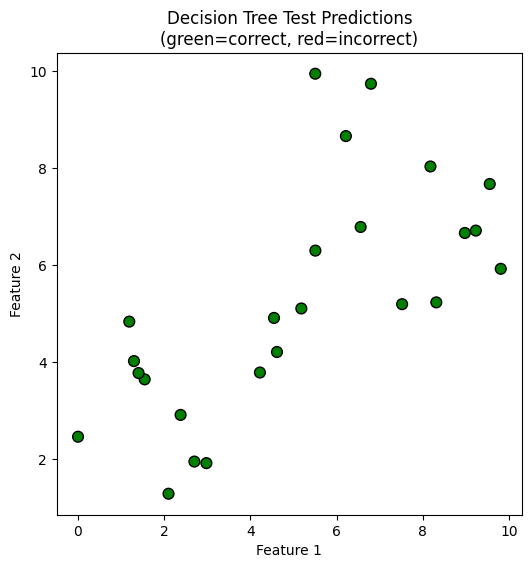

In [12]:
test_x = [pt[0] for pt in X_test]
test_y = [pt[1] for pt in X_test]
colors = ['green' if true==pred else 'red' for true, pred in zip(y_test, y_pred)]

plt.figure(figsize=(6,6))
plt.scatter(test_x, test_y, c=colors, edgecolors='k', s=60)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Tree Test Predictions\n(green=correct, red=incorrect)')
plt.show()

### What we have understood:
The part of `class DecisionTreeStump()` partially explains that a Decision Tree (specifically a decision stump, meaning only one split) chooses the best feature and threshold that splits the training data into pure subgroups by minimising Gini Impurity:
Gini = `1 − ∑ (pᵢ)²`
* Where pᵢ is the proportion of class i in the group.
Note: Explanation of proportion of class with example:

##### Let’s say you have a group of 10 samples, where:

* ##### 7 belong to class 0
* ##### 3 belong to class 1

##### Then the class probabilities are:

- ##### $p_0 = \frac{7}{10} = 0.7$  
- ##### $p_1 = \frac{3}{10} = 0.3$

##### Now, applying the Gini Impurity formula:

$$
\text{Gini} = 1 - (p_0^2 + p_1^2) = 1 - (0.7^2 + 0.3^2) = 1 - (0.49 + 0.09) = 0.42
$$

* #####  So, the Gini impurity for this split is **0.42**


The decision stump checks both features and all possible midpoints as thresholds, and keeps the one with the lowest impurity.

It is essentially a one-step `"if‑else"` classifier: `“If feature < threshold, predict class A; else, class B”`.

In summary, Decision Trees recursively divide the space, but stumps stop after a single, optimal split.